# 3D Image Segmentation with a 2D UNET

# 1) Imports and mount

In [1]:
%load_ext autoreload
%autoreload 2

# This sets up the appropriate logging and path configs
from notebook_setup import * 

In [2]:
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

from monai.losses import DiceLoss
from src.features.build_features import train_transform, val_transform, test_transform

from src.visualization.visualize import view_slice

from monai.data import Dataset, DataLoader
from src.enums import DataDict

from src.settings.config import get_app_settings
from src.utils import load_yaml

## 2) Import Settings

In [3]:
settings = get_app_settings()
model_config = load_yaml("model_configs.yaml")

## 3.1) Sample Data

Get slices and save into a list dicts

In [4]:
from src.enums import INTERIM_TRAINING_DATA_PATHS, INTERIM_TESTING_DATA_PATHS
from src.pytorch_utils import get_interim_data_path

interim_train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
interim_test_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

In [35]:
import tempfile

def create_temp_file(api_data):
    # Create a temporary file
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        # Write the API data to the temporary file
        temp_file.write(api_data)

    # Return the path to the temporary file
    return temp_file.name

# Example usage:
api_string_bytes = b"Your API data here"

temp_file_path = create_temp_file(api_string_bytes)
print(f"Temporary file created: {temp_file_path}")


Temporary file created: C:\Users\zifen\AppData\Local\Temp\tmp0v57letb


## 3.3) Transforms

In [5]:
SEED = 2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 64

## 3.5) Dataset and Dataloader

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
train_paths = get_interim_data_path(INTERIM_TRAINING_DATA_PATHS)
val_paths = get_interim_data_path(INTERIM_TESTING_DATA_PATHS)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

15
tensor([[[-0.0358, -0.0358, -0.0361,  ..., -0.0372, -0.0371, -0.0371],
         [-0.0364, -0.0364, -0.0365,  ..., -0.0367, -0.0368, -0.0367],
         [-0.0366, -0.0365, -0.0365,  ..., -0.0359, -0.0362, -0.0360],
         ...,
         [-0.0357, -0.0358, -0.0358,  ..., -0.0370, -0.0371, -0.0371],
         [-0.0355, -0.0357, -0.0356,  ..., -0.0371, -0.0372, -0.0372],
         [-0.0356, -0.0357, -0.0357,  ..., -0.0372, -0.0371, -0.0371]]])

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])

T1: Min:-0.037225328385829926 Max: 0.6742489337921143


c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


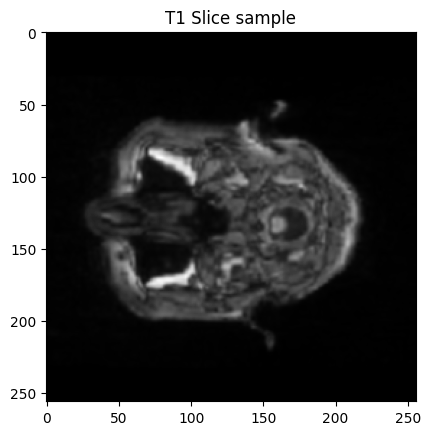

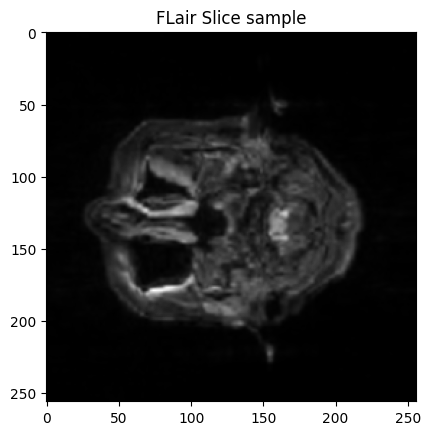

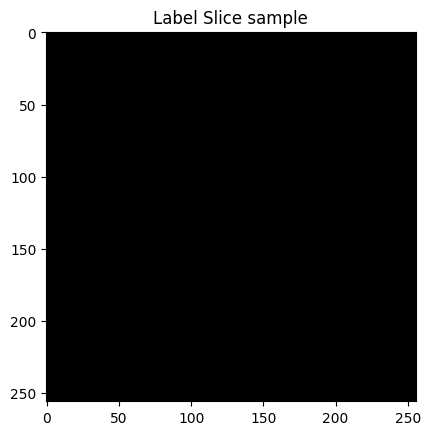

In [8]:
print(len(train_loader))

sample_data = train_dataset.__getitem__(1)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: \nImage {sample_tensor_image.shape} \nFlair {sample_tensor_flair.shape}\nT1 {sample_tensor_t1.shape}\nLabel {sample_tensor_label.shape}\n')

print(f"T1: Min:{torch.min(sample_tensor_t1)} Max: {torch.max(sample_tensor_t1)}")

view_slice(sample_tensor_image[0].squeeze().detach().cpu(), "T1 Slice sample", True)
view_slice(sample_tensor_image[1].squeeze().detach().cpu(), "FLair Slice sample", True)
view_slice(sample_tensor_label[1].squeeze().detach().cpu(), "Label Slice sample", True)

Shapes: 
Image torch.Size([2, 256, 256]) 
Flair torch.Size([1, 256, 256])
T1 torch.Size([1, 256, 256])
Label torch.Size([2, 256, 256])


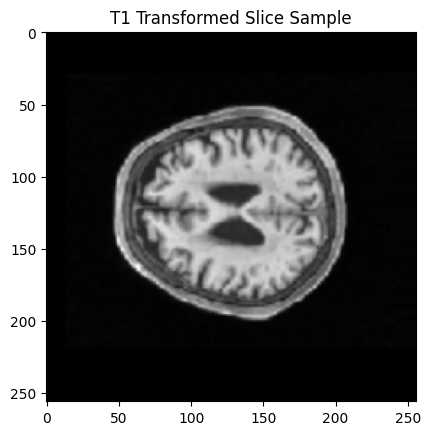

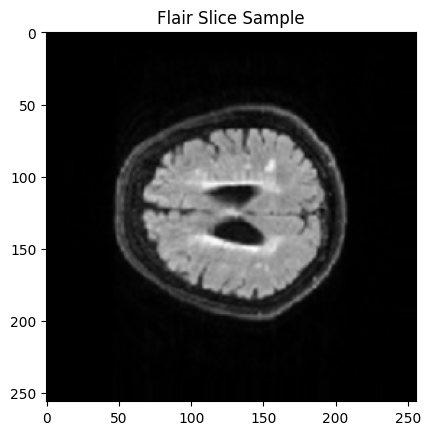

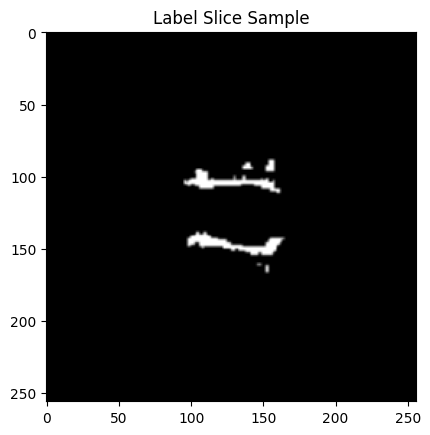

In [9]:
sample_data_2 = train_dataset.__getitem__(320)
sample_tensor_image2, sample_tensor_flair2, sample_tensor_t12, sample_tensor_label2 = sample_data_2[DataDict.Image], sample_data_2[DataDict.ImageFlair], sample_data_2[DataDict.ImageT1], sample_data_2[DataDict.Label]

print(f'Shapes: \nImage {sample_tensor_image2.shape} \nFlair {sample_tensor_flair2.shape}\nT1 {sample_tensor_t12.shape}\nLabel {sample_tensor_label2.shape}')
view_slice(sample_tensor_image2[0].squeeze().detach().cpu(), "T1 Transformed Slice Sample", True)
view_slice(sample_tensor_image2[1].squeeze().detach().cpu(), "Flair Slice Sample", True)
view_slice(sample_tensor_label2[1].squeeze().detach().cpu(), "Label Slice Sample", True)

# 4) Network

## 4.1) Train Network

## 4.3) Train data

In [10]:
from src.models.train_model import ModelTrainer, model, loss_function, optimizer, device
summary(model, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             304
            Conv2d-2         [-1, 16, 128, 128]             304
    InstanceNorm2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
             PReLU-5         [-1, 16, 128, 128]               1
            Conv2d-6         [-1, 16, 128, 128]           2,320
    InstanceNorm2d-7         [-1, 16, 128, 128]               0
           Dropout-8         [-1, 16, 128, 128]               0
             PReLU-9         [-1, 16, 128, 128]               1
     ResidualUnit-10         [-1, 16, 128, 128]               0
           Conv2d-11           [-1, 32, 64, 64]           4,640
           Conv2d-12           [-1, 32, 64, 64]           4,640
   InstanceNorm2d-13           [-1, 32, 64, 64]               0
          Dropout-14           [-1, 32,

c:\Users\zifen\Documents\Projects\wmh-segmentation\src\models\neural_net_models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [11]:
# model_trainer = ModelTrainer(
#         model,
#         train_loader,
#         validation_loader,
#     loss_function, optimizer, device, 2000, False, ""
# )
# net = model_trainer.train_model()

# 5) Test network

In [12]:
# Load the network for testing
pred_network = model

checkpoint = torch.load('models/single_slice_t1_flair_v1.pt', map_location=torch.device('cpu'))
epoch_checkpoint = checkpoint['epoch']
losses = checkpoint['losses']
val_losses = checkpoint['val_losses']
pred_network.load_state_dict(checkpoint['model_state_dict'])

# print(checkpoint['model_state_dict'])
print(epoch_checkpoint)
print(losses)
print(val_losses)



413
{0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 0.39340973, 64: 0.393221

{0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 0.39340973, 64: 0.39322177, 

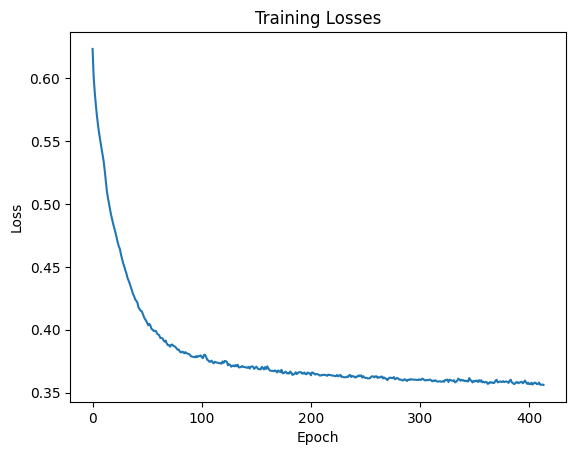

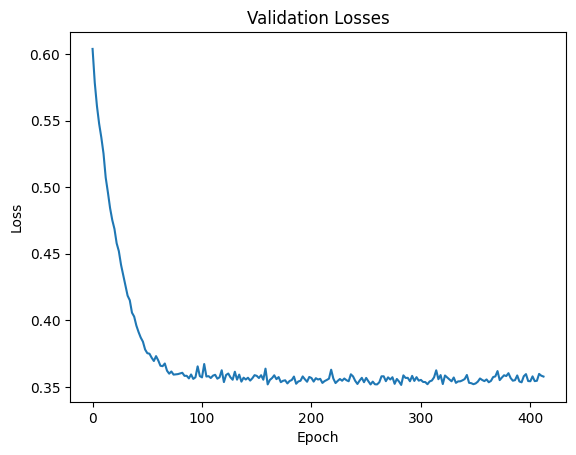

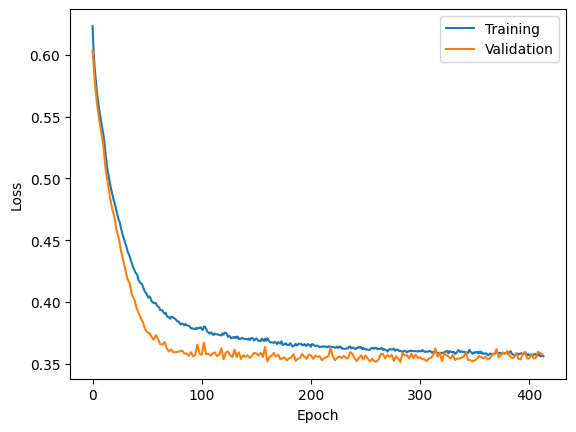

In [13]:
from src.pytorch_utils import dict_tensor_to_value
print(losses)
print(val_losses)


# Plot the validation and training losses
print(val_losses)
val_tensors = dict_tensor_to_value(val_losses)
print(val_tensors)

training_losses = sorted(losses.items()) # sorted by key, return a list of tuples
x, y = zip(*training_losses) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

validation_losses = sorted(val_tensors.items())
x2, y2 = zip(*validation_losses) # unpack a list of pairs into two tuples

plt.plot(x2, y2)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(x, y, label = "Training")
plt.plot(x2, y2, label = "Validation")
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from torchvision import models
from torchsummary import summary

summary(pred_network, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             304
            Conv2d-2         [-1, 16, 128, 128]             304
    InstanceNorm2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
             PReLU-5         [-1, 16, 128, 128]               1
            Conv2d-6         [-1, 16, 128, 128]           2,320
    InstanceNorm2d-7         [-1, 16, 128, 128]               0
           Dropout-8         [-1, 16, 128, 128]               0
             PReLU-9         [-1, 16, 128, 128]               1
     ResidualUnit-10         [-1, 16, 128, 128]               0
           Conv2d-11           [-1, 32, 64, 64]           4,640
           Conv2d-12           [-1, 32, 64, 64]           4,640
   InstanceNorm2d-13           [-1, 32, 64, 64]               0
          Dropout-14           [-1, 32,

# 6) Test Whole Volume

In [15]:
from src.models.predict_model import ImagePredictor

In [16]:
test_dataset.__getitem__(0).get(DataDict.Label).shape

torch.Size([2, 256, 256])

In [17]:
# test_datasaet
img_predictor = ImagePredictor(pred_network, test_dataset)
test_predictions = img_predictor.predict_handler()
print('DONE')

Predicting 1/2880 slices


c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\torch\_tensor.py:1386: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


Predicting 50/2880 slices
Predicting 100/2880 slices
Predicting 150/2880 slices
Predicting 200/2880 slices
Predicting 250/2880 slices
Predicting 300/2880 slices
Predicting 350/2880 slices
Predicting 400/2880 slices
Predicting 450/2880 slices
Predicting 500/2880 slices
Predicting 550/2880 slices
Predicting 600/2880 slices
Predicting 650/2880 slices
Predicting 700/2880 slices
Predicting 750/2880 slices
Predicting 800/2880 slices
Predicting 850/2880 slices
Predicting 900/2880 slices
Predicting 950/2880 slices
Predicting 1000/2880 slices
Predicting 1050/2880 slices
Predicting 1100/2880 slices
Predicting 1150/2880 slices
Predicting 1200/2880 slices
Predicting 1250/2880 slices
Predicting 1300/2880 slices
Predicting 1350/2880 slices
Predicting 1400/2880 slices
Predicting 1450/2880 slices
Predicting 1500/2880 slices
Predicting 1550/2880 slices
Predicting 1600/2880 slices
Predicting 1650/2880 slices
Predicting 1700/2880 slices
Predicting 1750/2880 slices
Predicting 1800/2880 slices
Predicting 1

In [18]:
# from monai.metrics import compute_meandice, DiceMetric

dice_scores = []

for i in range(len(test_predictions)):
    test_subject_prediction = test_predictions[i]

    print(test_subject_prediction[DataDict.Label].shape)
    print(test_subject_prediction[DataDict.Prediction].shape)

    pred = test_subject_prediction[DataDict.Prediction]
    label = test_subject_prediction[DataDict.Label]

    print(torch.max(pred))
    print(torch.min(pred))

    dice_metric = DiceLoss()
    # print(compute_meandice(pred, label))
    dice_score = 1 - dice_metric(pred, label)

    dice_scores.append(dice_score.item())


torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([256, 256, 48])
torch.Size([256, 256, 48])
tensor(1.)
tensor(0.)
torch.Size([

In [19]:
dice_scores


[0.9815140962600708,
 0.966586709022522,
 0.9902009963989258,
 0.9691082239151001,
 0.9058578610420227,
 0.9777428507804871,
 0.9894859790802002,
 0.9561915993690491,
 0.9678618907928467,
 0.9798822999000549,
 0.96888267993927,
 0.9897639751434326,
 0.9519736170768738,
 0.9784112572669983,
 0.9659574031829834,
 0.9520692825317383,
 0.9753952026367188,
 0.9364707469940186,
 0.9704351425170898,
 0.9867415428161621,
 0.9900296926498413,
 0.980666995048523,
 0.9729722142219543,
 0.9732721447944641,
 0.9844983220100403,
 0.9834015369415283,
 0.9848858714103699,
 0.9694156646728516,
 0.948653519153595,
 0.9798240661621094,
 0.9778563976287842,
 0.9741130471229553,
 0.9643986225128174,
 0.9934682250022888,
 0.9865897297859192,
 0.9918643832206726,
 0.9872784614562988,
 0.9612328410148621,
 0.9905246496200562,
 0.9800660014152527,
 0.9712381362915039,
 0.9762640595436096,
 0.983294665813446,
 0.9819896221160889,
 0.9602756500244141,
 0.975881040096283,
 0.973595917224884,
 0.9790866374969482,


In [20]:
from numpy import mean
mean_dice_score = round(mean(dice_scores), 5) 
mean_dice_score

0.9742

In [21]:

w = 200
h = 200
fig = plt.figure(figsize=(200, 600))
fig.set_figheight(h)
fig.set_figwidth(w)
columns = 8
rows = 12

label_count = 0
pred_count = 0
row = 1

for i in range(1, columns * rows + 1):  
    fig.add_subplot(rows, columns, i)
    # Prediction row
    if row % 2 != 0:
        plt.subplot(rows, columns, i).set_title(f'Prediction Depth {pred_count}', fontweight="bold", size=80)
        plt.imshow(pred[..., pred_count], cmap='gray')
        pred_count += 1
    # Label row
    else:
        plt.subplot(rows, columns, i).set_title(f'Label Depth {label_count}', fontweight="bold", size=80)
        plt.imshow(label[..., label_count], cmap='gray')
        label_count += 1

    
    row += 1 if i % 8 == 0 else 0
plt.show()

In [22]:
test_dataset.__getitem__(0).keys()

dict_keys([<DataDict.Id: 'subj_id'>, <DataDict.Image: 'image'>, <DataDict.ImageFlair: 'img_flair'>, <DataDict.ImageT1: 'img_t1'>, <DataDict.Label: 'label'>, <DataDict.DepthZ: 'depth_z'>])

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 2,please make sure the input is in the channel-first format.
  warnings.warn(


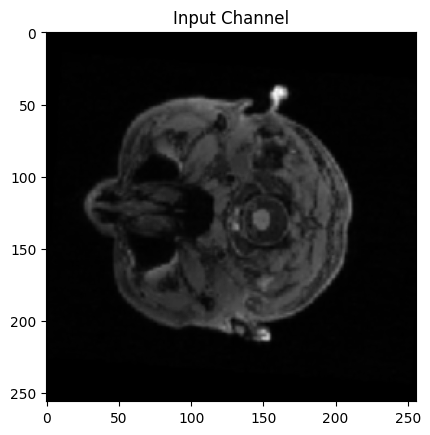

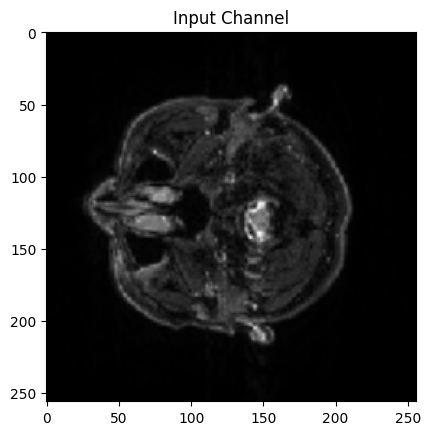

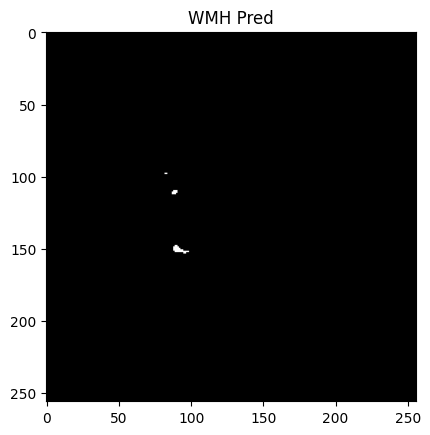

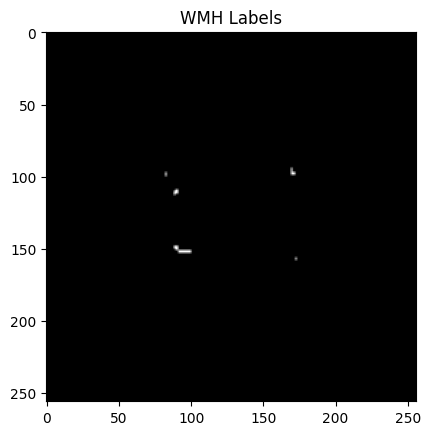

In [27]:
from src.pytorch_utils import numpy_from_tensor

subject_data = test_dataset.__getitem__(0)

view_slice(numpy_from_tensor(subject_data.get('img_t1')[0, ...]), f'Input Channel', gray=True)
view_slice(numpy_from_tensor(subject_data.get('img_flair')[0, ...]), f'Input Channel', gray=True)
view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)